This notebook should be used for loading, preprocessing, segmenting, and extracting the crystallinity features of a single polarized optical microscope (POM) image.
Calculation of the percent crystallinity of each image can also be performed and results will be stored as an output.

## Table of Contents:
1. POM Image Loading
2. Image Preprocessing
3. Watershed Image Segmentation
4. Crystallinity Feature Extraction
5. Percent Crystallinity Quantification

## POM Image Loading

This section is for loading the raw POM image. The image is displayed with a scale bar matching the calibration of the lens ([Olympus LMPLFLN 10X Objective - Edmund Optics](https://www.edmundoptics.com/p/olympus-lmplfln-10x-objective/30478/)).  
Spatial calibration was such that 130 pixels are equivalent to 60 microns.


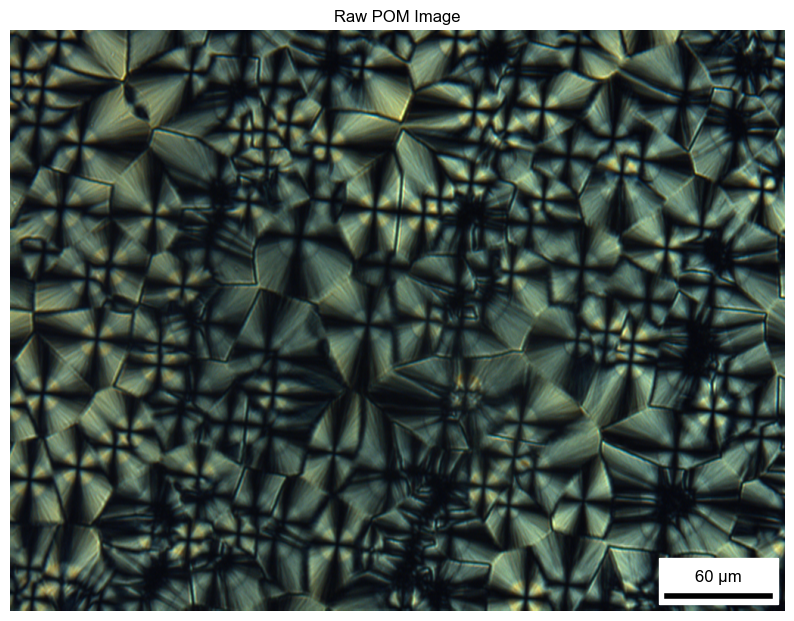

In [1]:
import sys
sys.path.append("../../src")  # Ensure Python finds the module

from data_loading import image_loader

# Define image path
image_path = "../../data/raw/S33.tif"

# Load the raw POM image
raw_image = image_loader.load_image(image_path)

# Display the POM image with a scale bar included
from visualization import image_with_scale_bar

image_with_scale_bar.display_image(raw_image, title = "Raw POM Image")


## Image Preprocessing

The preprocessing stage involves:  
1. Converting the image to grayscale  
2. Applying Gaussian blur to reduce noise  
3. Thresholding to create a binary image 
      - Global thresholding for uniform lighting and contrast conditions; adaptive thresholding for varied lighting conditions.
      - Optional parameter adjustments for Threshold value (for global thresholding), Block size (for adaptive thresholding), and Constant (C) subtracted from the mean.
4. Morphological operations for noise removal 
      - Opening to remove small bright spots (white noise) in the binary image; dilation to expand foreground objects to ensure proper segmentation.
      - Optional parameter adjustments for Kernel size and Number of iterations for dilation.
5. Computing markers for watershed segmentation  
      - Markers help to define sure foreground (objects to be segmented) in white, sure background (empty regions) in black, and unknown regions (boundaries between objects) in gray.


---

**_How to modify parameters:_**  

| Scenario | Recommended Adjustments |
|-------------|----------------------------|
| *Image has noise* | Increase blurring (kernel size *5x5* or larger), apply more noise removal operations (opening with *5x5* kernel). |
| *Objects are merging in segmentation* | Lower the threshold value (*100–120*), or increase the block size (*15+*) for adaptive thresholding. |
| *Small features are missing* | Reduce blurring (*3x3* kernel), decrease the constant (*C = 2–3*) in adaptive thresholding. |
| *Foreground is not well detected* | Adjust the foreground threshold (*0.3 × max distance transform* to *0.5 × max distance transform*). |
| *Uneven lighting* | Use adaptive thresholding with a larger block size (*21+*). |




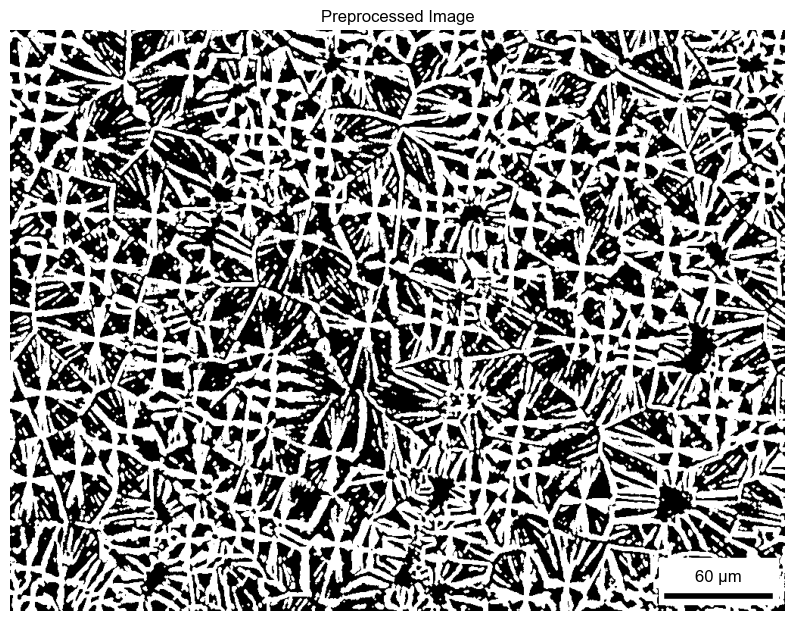

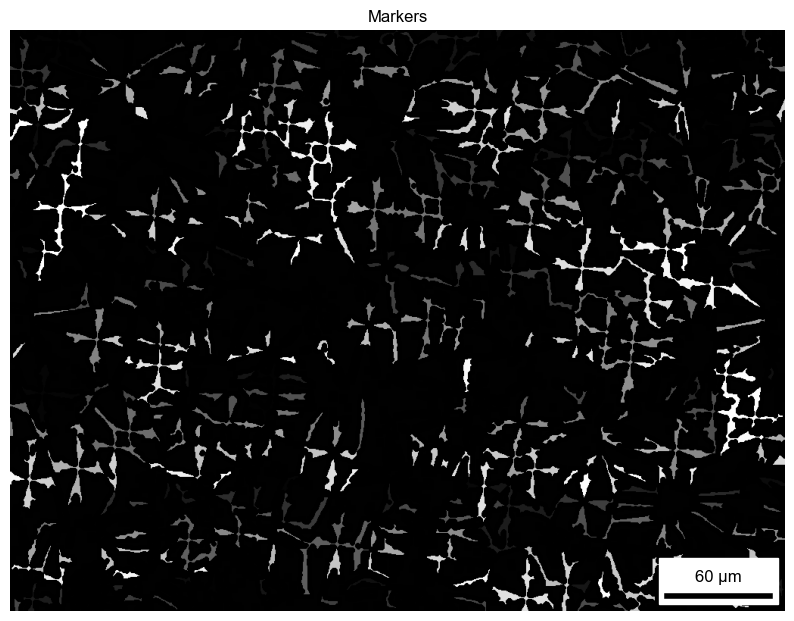

In [2]:
import cv2

from preprocessing import preprocessing_old

# Define preprocessing parameters (ADJUST HERE)
blur_kernel = (5,5)  # Adjust Gaussian blur strength
threshold_method = cv2.THRESH_BINARY_INV  # Choose thresholding method
threshold_value = 120  # Adjust threshold value for global thresholding
adaptive = True  # Use adaptive thresholding?
block_size = 17  # Block size for adaptive thresholding
C = 3  # Adjust C to balance region separation

# Enable additional features
use_edge_detection = False  # Enable Canny edge detection
use_gradient_thresholding = False  # Enable Laplacian filtering
enhance_contrast = True  # Improves local contrast using CLAHE
detect_grain_boundaries = True  # Enhances spherulite separation

# Preprocess image with new options
preprocessed_image = preprocessing_old.preprocess_image(raw_image, blur_kernel, threshold_method, threshold_value, adaptive, block_size, C,
    use_edge_detection, 
    use_gradient_thresholding, enhance_contrast, detect_grain_boundaries
)

image_with_scale_bar.display_image(preprocessed_image, title="Preprocessed Image")

# Define marker computation parameters (ADJUST HERE)
morph_kernel_size = (3,3)  # Morphological operations kernel size
dilation_iter = 2  # Number of dilation iterations
dist_transform_factor = 0.3  # Threshold factor for foreground detection
min_foreground_area = 50  # Minimum size of foreground components to keep

# Compute markers
maltese_cross_markers = preprocessing_old.compute_markers(preprocessed_image, morph_kernel_size, dilation_iter, 
                                        dist_transform_factor, min_foreground_area)

image_with_scale_bar.display_image(maltese_cross_markers, title="Markers")


## Watershed Image Segmentation

**Citation:**  
Gonzalez, R. C., & Woods, R. E. (2018). *Digital Image Processing* (4th ed.). Pearson.

---

The **watershed algorithm** is a morphological image segmentation technique that interprets a grayscale image as a topographic surface, where intensity values correspond to elevation. It is especially effective for separating overlapping or touching regions, such as birefringent domains in polarized optical microscopy (POM) images.

---

#### 1. Topographic Surface and Catchment Basins  
Let $f(x, y)$ be a grayscale image. Each pixel intensity represents an elevation on a topographic surface. Regional minima in $f$ correspond to **catchment basins**, and higher values represent **ridges**.

Let $M = \{m_1, m_2, ..., m_n\}$ be the set of all regional minima in $f$. Each $m_i$ defines the bottom of a basin.

---

#### 2. Immersion Simulation  
The watershed transform simulates a flooding process starting from the minima. At each intensity level $h$, we define:

$$
T_h = \{(x, y) \mid f(x, y) \leq h\}
$$

This is the set of pixels "submerged" by the flooding up to level $h$. Each connected component in $T_h$ is assigned a label corresponding to its source minimum. When regions from different minima are about to merge, **watershed lines** are placed to prevent merging.

---

#### 3. Watershed Lines  
The **watershed lines** $W$ are the set of points where catchment basins would merge. These define the boundaries between segmented regions:

$$
W = \{(x, y) \mid (x, y) \in T_h \text{ and } (x, y) \notin C_i \text{ for any } i\}
$$

where $C_i$ is the catchment basin associated with minimum $m_i$.

---

#### 4. Marker-Controlled Watershed  
To reduce **oversegmentation**, a marker-controlled approach is often used. Here, predefined **foreground** ($F$) and **background** ($B$) markers guide the flooding process. The algorithm is applied to a gradient image $g(x, y)$, and the segmentation is defined by:

$$
W = \text{Watershed}(g(x, y), F \cup B)
$$

This ensures that only meaningful regions are segmented, based on prior knowledge encoded in the markers.

---

This approach is highly effective in quantifying semicrystalline domains, where accurate segmentation of overlapping features is essential.


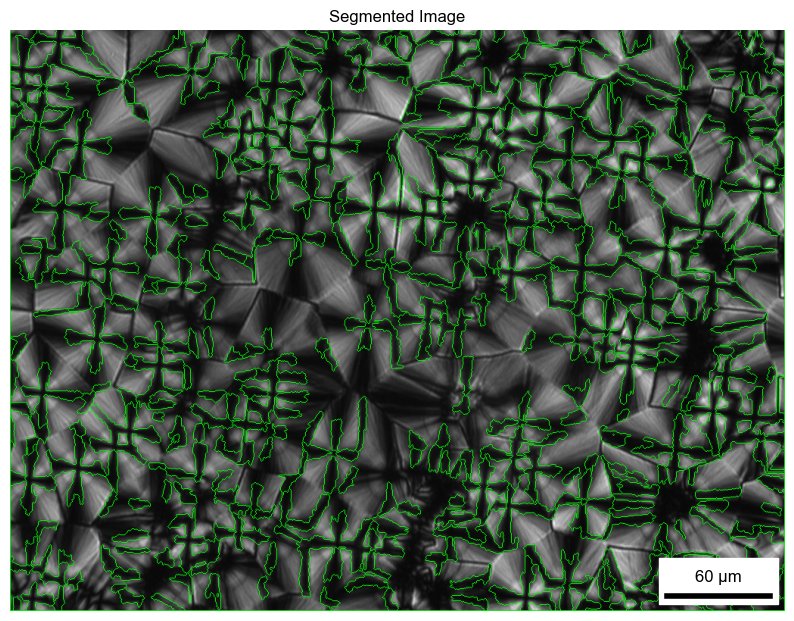

In [3]:
from segmentation import watershed_segmentation

# Applying watershed segmentation
segmented_image, segmented_labels = watershed_segmentation.apply_watershed(raw_image, maltese_cross_markers)

# Display the result
image_with_scale_bar.display_image(segmented_image, title="Segmented Image")

## Crystallinity Feature Extraction

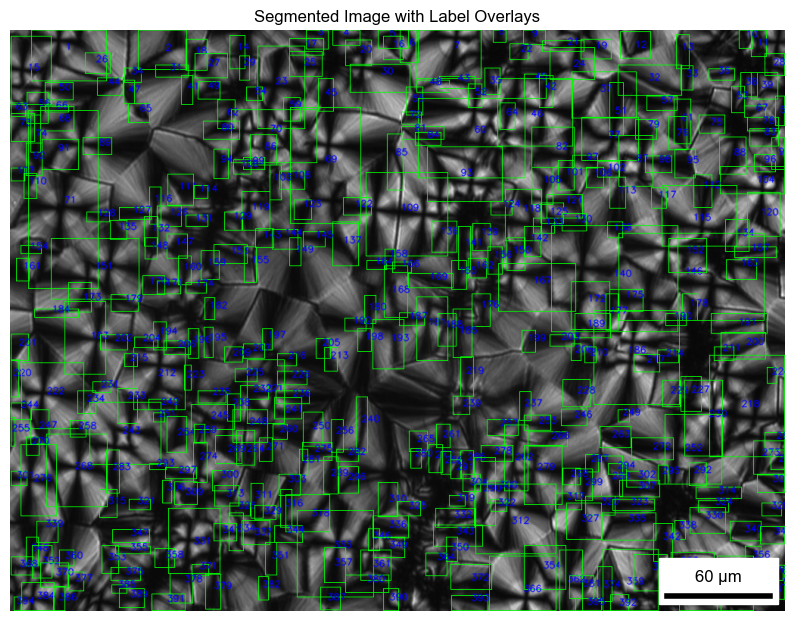

In [4]:
from feature_extraction import feature_extract

# Clean + extract features
cleaned_labels = feature_extract.clean_watershed_labels(segmented_labels)
features_df = feature_extract.extract_region_features(cleaned_labels, raw_image)

# Overlay labels
labeled_overlay = feature_extract.overlay_labels_on_image(cleaned_labels, raw_image)

# Display
image_with_scale_bar.display_image(labeled_overlay, title="Segmented Image with Label Overlays")



## Percent Crystallinity Quantification